## Week 4 Homework Submission

In this homework, we will use the Car price dataset like last week. Download it from [here](https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/chapter-02-car-price/data.csv).

Or you can do it with `wget`:

```bash
wget https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/chapter-02-car-price/data.csv
```

We'll work with the `MSRP` variable, and we'll transform it to a classification task. 

For the rest of the homework, you'll need to use only these columns:

* `Make`,
* `Model`,
* `Year`,
* `Engine HP`,
* `Engine Cylinders`,
* `Transmission Type`,
* `Vehicle Style`,
* `highway MPG`,
* `city mpg`
* `MSRP`


### Data preparation

* Keep only the columns above
* Lowercase the column names and replace spaces with underscores
* Fill the missing values with 0 
* Make the price binary (1 if above the average, 0 otherwise) - this will be our target variable `above_average`

Split the data into 3 parts: train/validation/test with 60%/20%/20% distribution. Use `train_test_split` function for that with `random_state=1`

In [1]:
!wget https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/chapter-02-car-price/data.csv

--2023-10-07 21:18:43--  https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/chapter-02-car-price/data.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1475504 (1.4M) [text/plain]
Saving to: ‘data.csv’

data.csv            100%[===================>]   1.41M  --.-KB/s    in 0.05s   

2023-10-07 21:18:43 (30.2 MB/s) - ‘data.csv’ saved [1475504/1475504]



In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mutual_info_score
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression, LinearRegression

In [5]:
df = pd.read_csv('data.csv')

### Clean the data

In [6]:
features = ['Make', 'Model', 'Year', 'Engine HP',
       'Engine Cylinders', 'Transmission Type', 'Vehicle Style',
       'highway MPG', 'city mpg', 'MSRP']
df = df[features]
df.columns = df.columns.str.replace('MSRP','price').str.replace(' ','_').str.lower()
df = df.fillna(0)
df.head(), df.isnull().sum()

(  make       model  year  engine_hp  engine_cylinders transmission_type  \
 0  BMW  1 Series M  2011      335.0               6.0            MANUAL   
 1  BMW    1 Series  2011      300.0               6.0            MANUAL   
 2  BMW    1 Series  2011      300.0               6.0            MANUAL   
 3  BMW    1 Series  2011      230.0               6.0            MANUAL   
 4  BMW    1 Series  2011      230.0               6.0            MANUAL   
 
   vehicle_style  highway_mpg  city_mpg  price  
 0         Coupe           26        19  46135  
 1   Convertible           28        19  40650  
 2         Coupe           28        20  36350  
 3         Coupe           28        18  29450  
 4   Convertible           28        18  34500  ,
 make                 0
 model                0
 year                 0
 engine_hp            0
 engine_cylinders     0
 transmission_type    0
 vehicle_style        0
 highway_mpg          0
 city_mpg             0
 price                0
 dtype:

### Clean the categorical variables and create 'above_average' target variable

In [7]:
categorical = list(df.dtypes[df.dtypes == 'object'].index)
numerical = list(df.dtypes[df.dtypes != 'object'].index)

# convert all categorical variables to lowercase and replace spaces with underscore
for c in categorical:
    df[c] = df[c].str.lower().str.replace(' ', '_')

# add the above_average target variable
df['above_average'] = (df['price'] > df['price'].mean()).astype(int)

df.head, df['above_average'].value_counts(normalize=False)

(<bound method NDFrame.head of           make       model  year  engine_hp  engine_cylinders  \
 0          bmw  1_series_m  2011      335.0               6.0   
 1          bmw    1_series  2011      300.0               6.0   
 2          bmw    1_series  2011      300.0               6.0   
 3          bmw    1_series  2011      230.0               6.0   
 4          bmw    1_series  2011      230.0               6.0   
 ...        ...         ...   ...        ...               ...   
 11909    acura         zdx  2012      300.0               6.0   
 11910    acura         zdx  2012      300.0               6.0   
 11911    acura         zdx  2012      300.0               6.0   
 11912    acura         zdx  2013      300.0               6.0   
 11913  lincoln      zephyr  2006      221.0               6.0   
 
       transmission_type  vehicle_style  highway_mpg  city_mpg  price  \
 0                manual          coupe           26        19  46135   
 1                manual    co

### Split the data into train, validate and test sets

In [15]:
# split the data
seed = 1
test_size = 0.2
train_size = 0.2

In [16]:
#split the dat

df_full_train, df_test = train_test_split(df, test_size=test_size, random_state=seed)
df_train, df_val = train_test_split(df_full_train, test_size=train_size, random_state=seed)

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = df_train.above_average.values
y_val = df_val.above_average.values
y_test = df_test.above_average.values

del df_train['price']
del df_train['above_average']

del df_val['price']
del df_val['above_average']

del df_test['price']
del df_test['above_average']

len(df_train), len(df_val), len(df_test)

(7624, 1907, 2383)

### Question 1: ROC AUC feature importance

ROC AUC could also be used to evaluate feature importance of numerical variables. 

Let's do that

* For each numerical variable, use it as score and compute AUC with the `above_average` variable
* Use the training dataset for that


If your AUC is < 0.5, invert this variable by putting "-" in front

(e.g. `-df_train['engine_hp']`)

AUC can go below 0.5 if the variable is negatively correlated with the target varialble. You can change the direction of the correlation by negating this variable - then negative correlation becomes positive.

Which numerical variable (among the following 4) has the highest AUC?

- `engine_hp`
- `engine_cylinders`
- `highway_mpg`
- `city_mpg`

In [20]:
from sklearn.metrics import roc_auc_score, auc

In [27]:
q1_features = ['engine_hp', 'engine_cylinders', 'highway_mpg', 'city_mpg']

auc_vals = {}
for f in q1_features:
    auc_score = roc_auc_score(y_train, df_train[f])

    if auc_score < 0.5:
        auc_score = roc_auc_score(y_train, -df_train[f])

    auc_vals[f] = auc_score

print(auc_vals), print(max(auc_vals, key=auc_vals.get))

{'engine_hp': 0.9162324220917971, 'engine_cylinders': 0.7674408924408924, 'highway_mpg': 0.6351930621461872, 'city_mpg': 0.6754616043678544}
engine_hp


(None, None)

### Question 2: Training the model

Apply one-hot-encoding using `DictVectorizer` and train the logistic regression with these parameters:

```python
LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
```

What's the AUC of this model on the validation dataset? (round to 3 digits)

- 0.678
- 0.779
- 0.878
- 0.979

In [30]:
categorical = list(df_train.dtypes[df_train.dtypes == 'object'].index)
numerical = list(df_train.dtypes[df_train.dtypes != 'object'].index)
categorical+numerical

['make',
 'model',
 'transmission_type',
 'vehicle_style',
 'year',
 'engine_hp',
 'engine_cylinders',
 'highway_mpg',
 'city_mpg']

In [31]:
def train(df_train, y_train, C=1.0):
    dicts = df_train[categorical + numerical].to_dict(orient='records')

    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(dicts)

    model = LogisticRegression(C=C, solver='liblinear', max_iter=1000)
    model.fit(X_train, y_train)
    
    return dv, model

def predict(df, dv, model):
    dicts = df[categorical + numerical].to_dict(orient='records')

    X = dv.transform(dicts)
    y_pred = model.predict_proba(X)[:, 1]

    return y_pred

In [33]:
dv, model = train(df_train, y_train, C=1.0)
y_pred = predict(df_val, dv, model)

In [36]:
auc = roc_auc_score(y_val, y_pred)
round(auc,3)

0.978

### Question 3: Precision and Recall

Now let's compute precision and recall for our model.

* Evaluate the model on all thresholds from 0.0 to 1.0 with step 0.01
* For each threshold, compute precision and recall
* Plot them

At which threshold precision and recall curves intersect?

* 0.28
* 0.48
* 0.68
* 0.88

In [51]:
thresholds = np.arange(0, 1, .01)
scores = []

for t in thresholds:
    actual_positive = (y_val == 1)
    actual_negative = (y_val == 0)

    predict_positive = (y_pred >= t)
    predict_negative = (y_pred < t)

    tp = (predict_positive & actual_positive).sum()
    fp = (predict_positive & actual_negative).sum()
    tn = (predict_negative & actual_negative).sum()
    fn = (predict_negative & actual_positive).sum()

    p = tp / (tp + fp)
    r = tp / (tp + fn)

    scores.append((t, p, r))

columns = ['threshold', 'precision', 'recall']
df_pr = pd.DataFrame(scores, columns=columns)

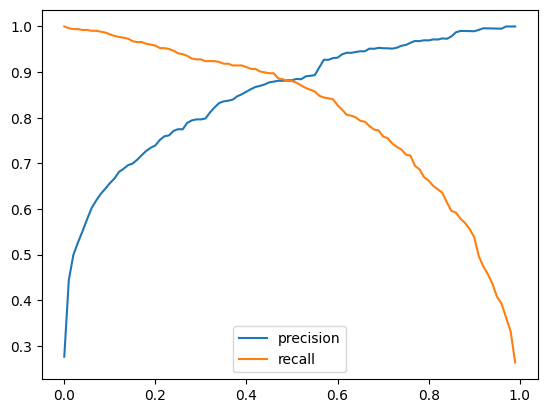

In [40]:
plt.plot(df_pr.threshold, df_pr['precision'], label='precision')
plt.plot(df_pr.threshold, df_pr['recall'], label='recall')
plt.legend()

In [48]:
df_pr['difference'] = abs(df_pr['precision'] - df_pr['recall'])
df_pr[df_pr['difference'] == df_pr['difference'].min()]

,threshold,precision,recall,difference
49,0.49,0.882129,0.880455,0.001674
50,0.50,0.882129,0.880455,0.001674


### Question 4: F1 score

Precision and recall are conflicting - when one grows, the other goes down. That's why they are often combined into the F1 score - a metrics that takes into account both

This is the formula for computing F1:

$$F_1 = 2 \cdot \cfrac{P \cdot R}{P + R}$$

Where $P$ is precision and $R$ is recall.

Let's compute F1 for all thresholds from 0.0 to 1.0 with increment 0.01

At which threshold F1 is maximal?

- 0.12
- 0.32
- 0.52
- 0.72

In [55]:
df_pr['f1'] = (2 * df_pr['precision'] * df_pr['recall']) / (df_pr['precision'] + df_pr['recall'])
df_pr[df_pr['f1'] == df_pr['f1'].max()]

,threshold,precision,recall,f1
46,0.46,0.879182,0.897533,0.888263


### Question 5: 5-Fold CV


Use the `KFold` class from Scikit-Learn to evaluate our model on 5 different folds:

```
KFold(n_splits=5, shuffle=True, random_state=1)
```

* Iterate over different folds of `df_full_train`
* Split the data into train and validation
* Train the model on train with these parameters: `LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)`
* Use AUC to evaluate the model on validation

How large is standard devidation of the scores across different folds?

- 0.003
- 0.030
- 0.090
- 0.140

In [61]:
from sklearn.model_selection import KFold
from tqdm import tqdm

In [58]:
n_splits = 5

kfold = KFold(n_splits=n_splits, shuffle=True, random_state=1)

scores = []

for train_idx, val_idx in kfold.split(df_full_train):
    df_train = df_full_train.iloc[train_idx]
    df_val = df_full_train.iloc[val_idx]

    y_train = df_train.above_average.values
    y_val = df_val.above_average.values

    dv, model = train(df_train, y_train)
    y_pred = predict(df_val, dv, model)

    auc = roc_auc_score(y_val, y_pred)
    scores.append(auc)

print('%.3f +- %.3f' % (np.mean(scores), np.std(scores)))

0.979 +- 0.002


### Question 6: Hyperparemeter Tuning

Now let's use 5-Fold cross-validation to find the best parameter `C`

* Iterate over the following `C` values: `[0.01, 0.1, 0.5, 10]`
* Initialize `KFold` with the same parameters as previously
* Use these parametes for the model: `LogisticRegression(solver='liblinear', C=C, max_iter=1000)`
* Compute the mean score as well as the std (round the mean and std to 3 decimal digits)

Which `C` leads to the best mean score?

- 0.01
- 0.1
- 0.5
- 10

If you have ties, select the score with the lowest std. If you still have ties, select the smallest `C`.

In [63]:
n_splits = 5

for C in tqdm([0.01, 0.1, 0.1, 0.5, 10]):
    kfold = KFold(n_splits=n_splits, shuffle=True, random_state=1)

    scores = []

    for train_idx, val_idx in kfold.split(df_full_train):
        df_train = df_full_train.iloc[train_idx]
        df_val = df_full_train.iloc[val_idx]

        y_train = df_train.above_average.values
        y_val = df_val.above_average.values

        dv, model = train(df_train, y_train, C=C)
        y_pred = predict(df_val, dv, model)

        auc = roc_auc_score(y_val, y_pred)
        scores.append(auc)

    print('C=%s %.3f +- %.3f' % (C, np.mean(scores), np.std(scores)))

 20%|██████████████████████████▍                                                                                                         | 1/5 [00:01<00:05,  1.39s/it]

C=0.01 0.952 +- 0.002


 40%|████████████████████████████████████████████████████▊                                                                               | 2/5 [00:02<00:03,  1.32s/it]

C=0.1 0.972 +- 0.002


 60%|███████████████████████████████████████████████████████████████████████████████▏                                                    | 3/5 [00:03<00:02,  1.30s/it]

C=0.1 0.972 +- 0.002


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌                          | 4/5 [00:05<00:01,  1.30s/it]

C=0.5 0.980 +- 0.003


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:06<00:00,  1.32s/it]

C=10 0.984 +- 0.003
